## A brief introduction to LSTMs

In order to begin talking about LSTMs, it is necessary to have a rudimentary understanding of Recurrent Neural Networks (RNNs). A RNN architecture utilizes the baseline neural network and constructs a loop with which it can retain information learned in prior events. By making this modification to the traditional NN, the RNN allows learning to be cumulative over a span of events. This difference provides a significant leap in predictive power: instead of learning how to classify an event from scratch upon every occurrence, a RNN can use the sequence leading to the current instance to make an informed decision about its class. 

<img src="RNN.png">

This type of network has proven highly successful in applications including language modeling, image captioning, speech recognition, text prediction, and a host of others. One application familiar to the modern layman is the word suggestion feature on smartphones -- given a sequence of words typed, a new set of words is suggested, each a high-likelihood candidate for being the user's next choice. A RNN could be well employed in this setting.

One of the drawbacks of the RNN, however, is its difficulty in capturing long-term dependencies. If the current task requires information from an event far in the past, a RNN will have likely perform poorly. To combat the issue, the LSTM steps in.

A Long Short Term Memory (LSTM) unit is a type of recurrent neural network especially suited to learn from experiences with dependency gaps of unknown length. The LSTM unit implements a cell state, which is similar to a track across which information can flow easily across units.  Using gates made up a sigmoid neural net layer, the networks can regulate how much information to add or remove along the track. Once the information has been properly filtered, the cell state is put through another sigmoid layer that decides what parts to output. The cell state is finally pushed through *tanh* to map the value between *[-1,1]*, and multiplied by the output of the sigmoid to get the final output.

<img src="tanh.png">

Now we can move to evaluating the model's proficiency for character-sequential prediction. In the next section, we will use a LSTM for a language classification experiment.

## LSTMs for Language Detection

In this experiment, we will download some English and French text data from the Universal Declaration of Human Rights Database. To code the LSTM, we will use the keras library with TensorFlow backend.

In [1]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys

Using TensorFlow backend.


### Data setup & vectorization

Once we have the texts in our local directory, we can read them in and lowercase all characters to simplify our task.

In [11]:
text_eng = open('data/eng.txt').read().lower()
text_frn = open('data/frn.txt').read().lower()

To clean the data a bit further, I'll strip the end of line characters and make an array of the resulting space-separated strings. Now we can split each text set into a learning set containing 80% of the text, and a holdout set with the remaining 20%. Of course, these steps are done for both languages. 

In [40]:
text_eng_1 = text_eng.strip('\n').split(' ')
train_eng = text_eng_1[:len(text_eng_1)//10*8]
test_eng = text_eng_1[len(text_eng_1)//10*8:]

text_frn_1 = text_frn.strip('\n').split(' ')
train_frn = text_frn_1[:len(text_frn_1)//10*8]
test_frn = text_frn_1[len(text_frn_1)//10*8:]

We'll now re-join the arrays as strings in order to take note of some important features.

In [45]:
x_train_eng = ' '.join(train_eng)
x_test_eng = ' '.join(test_eng)

x_train_frn = ' '.join(train_frn)
x_test_frn = ''.join(test_frn)

We can see that the English and French learning sets each contain around 9000 characters +/- 500.

In [46]:
print('English corpus length: ', len(x_train_eng))
print('French corpus length: ', len(x_train_frn))

English corpus length:  8607
French corpus length:  9529


Let's now briefly join the two language sets in order to get the set of unique characters that define them. As we can see, there are 44 different characters.

In [196]:
chars = sorted(list(set(x_train_eng + x_train_frn)))
print('total chars: ', len(chars))

total chars:  44


To easily retrive the index of a *char* given its character and vice-versa, we create a pair of dictionaries.

In [197]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Next, we iterate through the English and French texts and create a series 5-character slices (sub-strings) and track each substring's next character. By doing this, we build a learning set which the LSTM can use to learn its assigned task: character prediction.

In [167]:
def cuttext(maxlen, text):
    step = 1
    sentences = []
    next_chars = []
    for i in range(0, len(text) - maxlen, step):
        sentences.append(text[i: i + maxlen])
        next_chars.append(text[i + maxlen])
    print('nb sequences:', len(sentences))
    return sentences, next_chars

In [472]:
sentences_eng, next_chars_eng = cuttext(5, x_train_eng)
sentences_frn, next_chars_frn = cuttext(5, x_train_frn)

nb sequences: 8602
nb sequences: 9524


To make sure our model will be able to read the data, we will vectorize the sentences we made into a "bag of chars" binary vector.

In [479]:
def vectorize(sentences, maxlen, chars, char_indices, next_chars):
    print('Vectorization...')
    X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
    y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            X[i, t, char_indices[char]] = 1
        #y[i, char_indices[next_chars[i]]] = 1
    return X #, y

In [473]:
X_eng, y_eng = vectorize(sentences_eng, 5, chars, char_indices,\
                         next_chars_eng)

Vectorization...


We can see that each of our N_samples has shape (5,44), meaning for each character in the string, there is a vector of length 44 where the corresponding char index is marked *True*, and all other indices are marked *False*.

In [514]:
print(X_eng.shape, y_eng.shape)

(8602, 5, 44) (8602, 44)


In [474]:
X_frn, y_frn = vectorize(sentences_frn, 5, chars, char_indices,\
                        next_chars_frn)

Vectorization...


### Model creation & training

Now we are ready to build the LSTM. We will make both models of size 128, use a softmax for activation type, and categorical crossentropy for the loss function. 

In [475]:
print('Build model for english...')
model_eng = Sequential()
model_eng.add(LSTM(128, input_shape=(5, len(chars))))
model_eng.add(Dense(len(chars)))
model_eng.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model_eng.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model for english...


In [476]:
print('Build model for french...')
model_frn = Sequential()
model_frn.add(LSTM(128, input_shape=(5, len(chars))))
model_frn.add(Dense(len(chars)))
model_frn.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model_frn.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model for french...


With the two models in hand, we can now train them with our vectorized learning set, the corresponding vectorized next chars, 5 epochs and batch size of 128. Since our dataset size is relatively small, we can expect the computational burden common to LSTM training to take less of a toll here.

In [498]:
model_eng.fit(X_eng, y_eng, epochs=5, batch_size=128)

Epoch 1/5
8602/8602 [==============================] - 6s - loss: 0.5639     
Epoch 2/5
8602/8602 [==============================] - 7s - loss: 0.5557     
Epoch 3/5
8602/8602 [==============================] - 6s - loss: 0.5458     
Epoch 4/5
8602/8602 [==============================] - 6s - loss: 0.5471     
Epoch 5/5
8602/8602 [==============================] - 5s - loss: 0.5324     


In [499]:
model_frn.fit(X_frn, y_frn, epochs=5, batch_size=128)

Epoch 1/5
9524/9524 [==============================] - 6s - loss: 0.6387     
Epoch 2/5
9524/9524 [==============================] - 6s - loss: 0.6273     
Epoch 3/5
9524/9524 [==============================] - 6s - loss: 0.6197     
Epoch 4/5
9524/9524 [==============================] - 6s - loss: 0.6193     
Epoch 5/5
9524/9524 [==============================] - 6s - loss: 0.6084     


### LSTM prediction & testing

With the training complete, we look to generate a test dataset from the holdout sets. From each of the English and French sets, we randomly select 100 5-char substrings. We then end up with 200 test strings. These are the x_test for evaluation. The y_test are 1 for english and 0 for French.

In [300]:
rands = np.random.randint(len(x_test_eng),size=100)
eng_substrings = [x_test_eng[rands[i]:rands[i]+5] for i in range(100) if x_test_eng[rands[i]:rands[i]+5] != '']
frn_substrings = [x_test_frn[rands[i]:rands[i]+5] for i in range(100) if x_test_frn[rands[i]:rands[i]+5] != '']

x_test = np.concatenate((eng_substrings, frn_substrings))
y_test = np.concatenate(([1]*100, [0]*100))

Since the current test set contains 200 length-5 strings, we create a new list of substrings that segments each string into its first *k* characters for a total of 5 new strings per original string. For example: *'shape'* is broken down into *'s','sh','sha','shap','shape'*.
With this structure, we will be able to calculate the conditional probability of each character in the string.

In [308]:
x_test_subs = []
for s in x_test:
    for i in range(len(s)):
        x_test_subs.append(s[:i+1])

Again, we vectorize our new length 1000 test set so our model can accept it as input and generate predictions.

In [480]:
x_test_subs_vect = vectorize(x_test_subs, 5, chars, char_indices, next_chars_test)

Vectorization...


In [516]:
print ('Shape of vectorized test set: ', x_test_subs_vect.shape)

Shape of vectorized test set:  (1000, 5, 44)


Now, we can use our English model to predict the next character for each of the strings in our test set. The result will be a (1000, 44) array, where for each string, a probability distribution is generated describing the likelihood of the next character. Since there are 44 characters in our set, each will be assigned a probability of being next.

In [500]:
prediction_eng = model_eng.predict(x_test_subs_vect)

Next, we want to calculate the log likelihood of a string for each model. To do this, we will move one character at a time, and calculate the probability of the next character given the prior sequence of characters of that string. An example of this computation would look like this for the English model on the word 'trump':

*Pr(trump) = Pr(t|START) x Pr(r|START,t) x ... x Pr(p|START,trum)*

Since we want the log likelihoods, we would take the sum of the log probabilities. We will run this process for both language models to get an estimate of the probability that the string was generated by each language. Unfortunately, the probability of trump is greater than 0.

In [526]:
def getlogprobs(x_test_SUBS, prediction, char_indices):
    all_log_probs = []
    #words = []
    for i in range(0,len(x_test_SUBS), 5):
        
        log_prob_sum = 0
        prob_sum = 0

        # get log probability of first char
        first_char = x_test_SUBS[i]
        prob_first_char = prediction[i][char_indices[first_char]]
        log_prob_sum += np.log(prob_first_char)
        if i < 10:
            print ('P('+ first_char + '|START) = ' + str(prob_first_char))

        # get log probability of next char given prior chars
        for c in range(4):
            true_next = x_test_SUBS[i + c + 1][-1:]
            cond_prob = prediction[i + c][char_indices[true_next]]
            if i < 10:
                print ('P('+ true_next + '|'+ x_test_SUBS[i+c]+') = ' + str(cond_prob))

            prob_sum += cond_prob
            log_prob_sum += np.log(cond_prob)
        if i < 10:
            print ('-'*25, '\n', 'P('+ x_test_SUBS[i+c+1]+ ') = ' + str(prob_sum)+'\n'+'-'*25)
        all_log_probs.append(log_prob_sum)
        #words.append(x_test_subs[i+c+1])
    return all_log_probs

We will log first few calculations of conditional probabilities to get an intuitive sense of how the process works.

In [527]:
logProbs_eng = getlogprobs(x_test_subs, prediction_eng, char_indices)

P( |START) = 0.0121222
P(n| ) = 0.0230972
P(a| n) = 0.139695
P(t| na) = 0.000203246
P(i| nat) = 0.0369919
------------------------- 
 P( nati) = 0.199986971988
-------------------------
P( |START) = 0.0121222
P(p| ) = 0.00040502
P(e| p) = 0.42182
P(r| pe) = 0.0043685
P(f| per) = 1.88513e-06
------------------------- 
 P( perf) = 0.42659554114
-------------------------


We then repeat the process using the LSTM trained with French text, and output the resulting conditional probabilities.

In [502]:
prediction_frn = model_frn.predict(x_test_subs_vect)

In [528]:
logProbs_frn = getlogprobs(x_test_subs, prediction_frn, char_indices)

P( |START) = 0.00197321
P(n| ) = 0.00818693
P(a| n) = 0.245834
P(t| na) = 0.00158867
P(i| nat) = 2.77115e-06
------------------------- 
 P( nati) = 0.255612757638
-------------------------
P( |START) = 0.00197321
P(p| ) = 0.000842998
P(e| p) = 0.047969
P(r| pe) = 0.000342633
P(f| per) = 7.30374e-07
------------------------- 
 P( perf) = 0.0491553147573
-------------------------


###  Evaluation

We are now ready to evaluate the results. Our chosen scoring metric is the ratio of the two log likelihoods. Therefore, for a given string, we have *score = log(Pr(string|english)) - log(Pr(string|french))*

In [511]:
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

In [507]:
y_hat = np.array(logProbs_eng) - np.array(logProbs_frn)

In [508]:
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
AUC = auc(fpr, tpr)

The resulting ROC curve shows us an AUC score of 0.6514

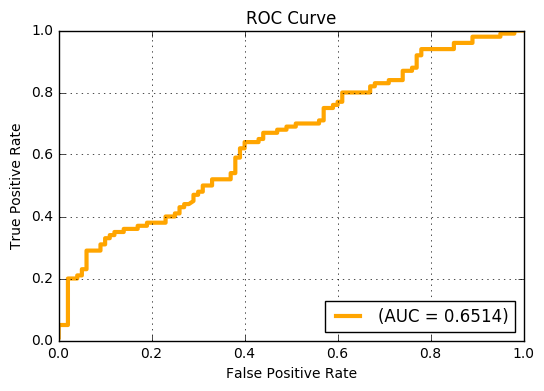

In [520]:
plt.figure()
plt.plot(fpr, tpr, linewidth=3, color='orange',label='(AUC = %0.4f)' % AUC)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

### Improvements?

Looking at the results of the ROC, we are not precisely ecstatic. An AUC of 0.65 is not immediately impressive, and while neither is an accuracy of 60%, it is certainly a great improvement over chance. Upon second review, we begin to realize that for a series of reasons, this classification task went suprisingly well.  

First, we consider the size of the datasets which we used to train the LSTMs. With only ~9,000 characters per model, the corpus sizes are extremely small by most standards. Throughout research and literature, it is recommended for the corpus to have at least 100k characters, if not 1M. With this in mind, the comparatively tiny data size we used to train the models yielded fairly impressive results. Therefore, given a much larger text corpus, we could expect the efficacy of this model to improve significantly.

Another alteration to the experiment that could improve results is the number of epochs we used to train the LSTM models. While we used only 5, many character-sequential prediction modelelers recommend using at least 20. With a 4-fold increase in training epochs, we may expect to see the LSTM output probability distributions closer to the language's true distribution. This means that the log probability of a string would be a better discriminator of language.

A third potential improvement might be increasing the *maxlen* parameter, which slices the text into substrings of length 5, in this experiment. By increasing this number to something like 50, we would capture much more of the string's context, allowing the LSTM to better learn language-specific patterns and sequences of characters. We could then expect the difference between the two model's  probability estimates to increase for a given string, making it easier to discern the language it belongs to. 

We could also try changing the LSTM model paramters. One possibility is to use a sigmoid activation function instead of a softmax. Many other LSTM experiments have been found to work optimally using sigmoid, and while improvement is not guaranteed, it provides us with the possibility of improvement. A similar argument can be made for experimenting with varios loss functions, such as binary cross entropy.

With our aforementioned wishes to increase corpus size as well as number of epochs, we need be mindful of the computational resources they would require. Given the notorious reputation RNNs have for being computationally intensive, we would need access to more powerful hardware if we are to improve our classification accuracy. Therefore, using a GPU and at least 16GB RAM would be the bare minimum. These resources would allow us to conduct larger-scale experimentation that would almost certainly improve our results.

### Alternative applications

An interesting alternative to language detection would be applying LSTMs to generate a sound or frequency after being trained with samples of music. Given the intricacy and compliexities of musical composition, it would be quite intriguing to hear what kind of "music" would be generated by a LSTM network. One could envision training with various genres and seeing which are easiest to mimic. This could aslo be attempted using musical notes instead of sound frequencies (what would be the difference?). The downside is that the model will likely fall well short of anything resembling human creativity and ingenuity.

Along a similar path, LSTMs could be used for speech recognition and prediction. This application could be especially useful in mending audio speech recordings with interruptions or dropped signals. An incomplete phrase could then be completed using the model to predict the set of words most likely to come. This could be used in recovering outdated audio recordings and any audio with noise. A difficulty, however, may be finding enough data to train the model with given the specific domain in which it is being applied.

Someone has probably already tried it, but applying LSTMs to the stock market might yield interesting results. This type of RNN is a specialist at learning from sequences and time series, and more than often the financial markets offer a nearly unsolvable problem in this setting. Given a sequence of prices over time and a set of factors such as economic indicators, a LSTM may be trained to predict the next most probable price level. Applying this to both long and short term horizons could lead to a potentially new form of pattern recognition in this domain. However, it would be extremely difficult to model all factors, especially those which are intangible or have no quantitative measure.

### Conclusion

In this examination of Long Short Term Memory networks, we became familiarized with how this type of RNN functions and what types of tasks it excels at. We then trained two LSTM models with English and French text in an effort to build a language classifier. Although the results were not as glamorous as desired, a list of potential improvements helped rationalize what we observed, and outlined how we could achieve better results. Lastly, some alternative applications of LSTMs were discussed.

### References
- https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py
- http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/